<a href="https://colab.research.google.com/github/RickStark/Reinforce-Learning-Practice/blob/main/RL_AC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()
        # Capa compartida (Cerebro base)
        self.feature_layer = nn.Linear(input_dim, hidden_dim)

        # Actor: Decide probabilidades de acción
        self.actor = nn.Linear(hidden_dim, action_dim)

        # Crítico: Estima el valor del estado (V)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.feature_layer(state))

        # Actor: Logits -> Probabilidades
        action_logits = self.actor(x)
        dist = Categorical(logits=action_logits)

        # Crítico: Valor escalar
        value = self.critic(x)

        return dist, value

In [2]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value # El valor del estado futuro (bootstrapping)
    returns = []

    # Vamos hacia atrás en el tiempo
    for step in reversed(range(len(rewards))):
        # R = recompensa + gamma * valor_futuro * (1 si no murió)
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)

    return returns

In [6]:
# --- HIPERPARÁMETROS ---
ENV_NAME = "CartPole-v1"
HIDDEN_DIM = 128
LR = 1e-3          # A2C suele tolerar learning rates un poco más altos que PPO
GAMMA = 0.99
NUM_STEPS = 100      # Cada cuántos pasos actualizamos la red (N-step updates)
MAX_EPISODES = 2000

# Configuración
env = gym.make(ENV_NAME)
input_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(input_dim, action_dim, HIDDEN_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Listas para gráficas
score_history = []

In [7]:
def train_a2c():
    print("Iniciando entrenamiento A2C...")

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        done = False
        score = 0

        # Buffers temporales para el lote (batch) pequeño
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0

        # Bucle del episodio
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # 1. Obtener acción y valor
            dist, value = model(state_tensor)

            action = dist.sample()

            # 2. Ejecutar paso
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            score += reward

            # 3. Guardar datos en memoria temporal
            log_probs.append(dist.log_prob(action))
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            # Sumamos entropía para fomentar exploración
            entropy += dist.entropy().mean()

            state = next_state

            # --- ACTUALIZACIÓN (UPDATE) ---
            # Si llenamos el buffer de pasos (NUM_STEPS) O si el episodio terminó
            if len(rewards) == NUM_STEPS or done:

                # Calcular el valor del siguiente estado (Bootstrapping)
                # Si terminamos (done), el valor futuro es 0.
                if done:
                    next_value = 0
                else:
                    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                    _, next_val = model(next_state_tensor)
                    next_value = next_val.item()

                # Calcular retornos (Objetivo del Crítico)
                returns = compute_returns(next_value, rewards, masks, GAMMA)

                returns = torch.cat(returns).detach() # Detach para que sean constantes
                log_probs = torch.cat(log_probs)
                values = torch.cat(values)
                rewards_tensor = torch.cat(rewards)

                # Advantage = Retorno Real - Valor Predicho
                advantage = returns - values

                # --- CÁLCULO DE LOSS ---
                actor_loss = -(log_probs * advantage.detach()).mean()
                critic_loss = advantage.pow(2).mean() # MSE Loss

                # Loss Total: Actor + Critico - Exploración (Entropía)
                loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

                # Optimización
                optimizer.zero_grad()
                loss.backward()

                # Clip gradiente (opcional pero recomendado en A2C para estabilidad)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()

                # Limpiar buffers
                log_probs = []
                values = []
                rewards = []
                masks = []
                entropy = 0

        # Fin del episodio
        score_history.append(score)

        avg_score = np.mean(score_history[-100:])
        if episode % 50 == 0:
            print(f"Episodio {episode} | Score: {score:.1f} | Promedio (100 ep): {avg_score:.1f}")

        if avg_score > 475:
            print(f"¡Juego resuelto en episodio {episode}!")
            break

train_a2c()

Iniciando entrenamiento A2C...
Episodio 0 | Score: 27.0 | Promedio (100 ep): 27.0
Episodio 50 | Score: 17.0 | Promedio (100 ep): 24.3
Episodio 100 | Score: 16.0 | Promedio (100 ep): 25.1
Episodio 150 | Score: 13.0 | Promedio (100 ep): 25.3
Episodio 200 | Score: 46.0 | Promedio (100 ep): 33.1
Episodio 250 | Score: 62.0 | Promedio (100 ep): 41.7
Episodio 300 | Score: 32.0 | Promedio (100 ep): 53.6
Episodio 350 | Score: 174.0 | Promedio (100 ep): 66.0
Episodio 400 | Score: 56.0 | Promedio (100 ep): 75.1
Episodio 450 | Score: 120.0 | Promedio (100 ep): 88.3
Episodio 500 | Score: 344.0 | Promedio (100 ep): 148.1
Episodio 550 | Score: 122.0 | Promedio (100 ep): 204.1
Episodio 600 | Score: 356.0 | Promedio (100 ep): 197.5
Episodio 650 | Score: 219.0 | Promedio (100 ep): 209.9
Episodio 700 | Score: 314.0 | Promedio (100 ep): 237.6
Episodio 750 | Score: 63.0 | Promedio (100 ep): 254.3
Episodio 800 | Score: 128.0 | Promedio (100 ep): 266.9
Episodio 850 | Score: 143.0 | Promedio (100 ep): 274.4
E

Modelo guardado.


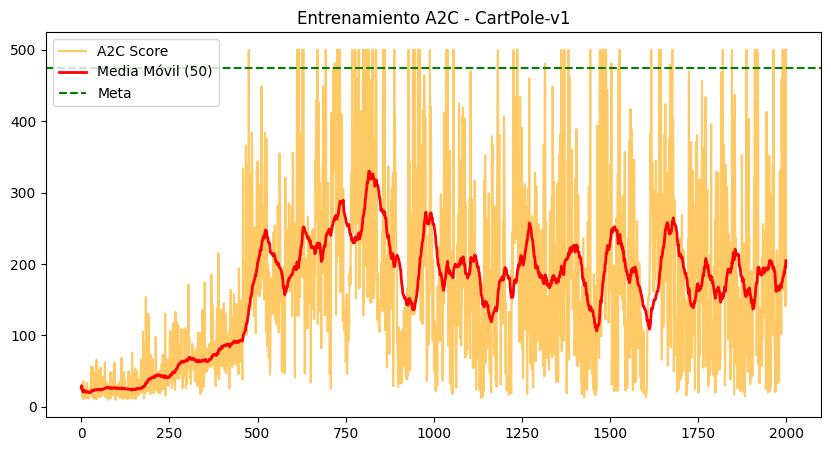

In [8]:
# Guardar modelo
torch.save(model.state_dict(), 'a2c_cartpole.pth')
print("Modelo guardado.")

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(score_history, label='A2C Score', alpha=0.6, color='orange')
# Media móvil
moving_avg = [np.mean(score_history[max(0, i-50):i+1]) for i in range(len(score_history))]
plt.plot(moving_avg, label='Media Móvil (50)', color='red', linewidth=2)
plt.axhline(y=475, color='green', linestyle='--', label='Meta')
plt.title("Entrenamiento A2C - CartPole-v1")
plt.legend()
plt.show()

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN ROBUSTA ---
ENV_NAME = "CartPole-v1"
NUM_ENVS = 8        # <--- CLAVE: 8 entornos paralelos
HIDDEN_DIM = 256
LR = 3e-4           # Learning rate más bajo para estabilidad (era 1e-3)
GAMMA = 0.99
NUM_STEPS = 5       # Pasos por update por entorno
MAX_UPDATES = 3000  # Total de actualizaciones

# Crear entornos vectorizados
# Esto crea 8 copias de CartPole que funcionan en paralelo
envs = gym.make_vec(ENV_NAME, num_envs=NUM_ENVS, vectorization_mode="async")

class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(ActorCritic, self).__init__()
        # Redes separadas para máxima estabilidad
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(), # Tanh a veces es más estable que ReLU en control
            nn.Linear(hidden_dim, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        action_logits = self.actor(state)
        dist = Categorical(logits=action_logits)
        value = self.critic(state)
        return dist, value

# Inicialización
input_dim = envs.single_observation_space.shape[0]
action_dim = envs.single_action_space.n
model = ActorCritic(input_dim, action_dim, HIDDEN_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Historial
score_history = []
global_step = 0

print(f"Iniciando entrenamiento con {NUM_ENVS} entornos paralelos...")

# --- 2. BUCLE DE ENTRENAMIENTO VECTORIZADO ---
# Estado inicial (ahora es una matriz [8, 4] en lugar de vector [4])
states, _ = envs.reset()

for update in range(MAX_UPDATES):
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropies = []

    # 1. Recolección de datos (n-steps)
    for _ in range(NUM_STEPS):
        states_tensor = torch.FloatTensor(states)
        dist, value = model(states_tensor)

        action = dist.sample()

        # step() ejecuta las 8 acciones a la vez
        next_states, reward, terminated, truncated, _ = envs.step(action.cpu().numpy())
        done = terminated | truncated # Operador OR bit a bit para arrays

        log_probs.append(dist.log_prob(action))
        values.append(value.squeeze())
        rewards.append(torch.FloatTensor(reward))
        masks.append(torch.FloatTensor(1 - done))
        entropies.append(dist.entropy())

        states = next_states
        global_step += NUM_ENVS # Contamos pasos totales

    # 2. Bootstrapping (Valor del siguiente estado)
    with torch.no_grad():
        next_states_tensor = torch.FloatTensor(states)
        _, next_val = model(next_states_tensor)
        next_value = next_val.squeeze()

    # 3. Cálculo de Retornos (Hacia atrás)
    returns = []
    R = next_value
    for step in reversed(range(NUM_STEPS)):
        R = rewards[step] + GAMMA * R * masks[step]
        returns.insert(0, R)

    # Convertir listas a tensores
    returns = torch.stack(returns)      # [NUM_STEPS, NUM_ENVS]
    values = torch.stack(values)        # [NUM_STEPS, NUM_ENVS]
    log_probs = torch.stack(log_probs)
    entropies = torch.stack(entropies)

    # Aplanar dimensiones (Batch completo)
    returns = returns.view(-1)
    values = values.view(-1)
    log_probs = log_probs.view(-1)
    entropies = entropies.view(-1)

    # 4. Cálculo de Loss
    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    entropy_loss = entropies.mean()

    # Loss total (Aumenté entropía a 0.01 para evitar estancamiento inicial)
    loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy_loss

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Clipping vital
    optimizer.step()

    # --- LOGGING (Truco para entornos vectorizados) ---
    # Gymnasium vectorizado guarda info extra cuando un episodio termina
    # Buscamos en 'final_info' para ver scores reales
    # Nota: esto depende de la versión de gym, usaremos un método aproximado si falla
    if update % 10 == 0:
        # Estimación simple basada en rewards promedio del batch actual
        # Multiplicamos por duración esperada aprox para tener una idea
        avg_reward_batch = returns.mean().item()
        score_history.append(avg_reward_batch)
        print(f"Update {update} | Value Promedio: {avg_reward_batch:.2f}")

envs.close()

# Visualizar
plt.plot(score_history)
plt.title("A2C Vectorizado (Más Estable)")
plt.xlabel("Updates")
plt.ylabel("Retorno Estimado")
plt.show()